# Spam Classification Part 2

The deadline for Part 1 is **2 pm Feb 19, 2020**.   
You should submit a `.ipynb` file with your solutions to NYU Classes.

---

In this homework, we will reuse the spam prediction dataset used in HW1-Part1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).



# Data Loading
First, reuse the code from HW1-Part1 to download and read the data.

In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2020-02-19 16:51:43--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.139, 74.125.20.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ev80hoppt91oh41iem7kk7f1132tltg9/1582130700000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2020-02-19 16:51:44--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ev80hoppt91oh41iem7kk7f1132tltg9/1582130700000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-docs.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [3]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [4]:
train_texts[:10] # Just checking the examples in train_text

['Goodmorning today i am late for  &lt;DECIMAL&gt; min.',
 'We live in the next  &lt;#&gt; mins',
 'I doubt you could handle 5 times per night in any case...',
 'Beautiful Truth against Gravity.. Read carefully: \\Our heart feels light when someone is in it.. But it feels very heavy when someone leaves it..\\" GOODMORNING"',
 'She ran off with a younger man. we will make pretty babies together :)',
 'I will come to ur home now',
 'Oh ok i didnt know what you meant. Yep i am baby jontin',
 'In life when you face choices Just toss a coin not becoz its settle the question But while the coin in the air U will know what your heart is hoping for. Gudni8',
 'K. I will sent it again',
 "She's borderline but yeah whatever."]

# Download and Load GloVe Embeddings
We will use GloVe embeddings as our word representations.  
Let's download and load glove. We will reuse the code from Lab 2 for downloading and loading GloVe


In [5]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-02-19 16:51:51--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 172.253.117.113, 172.253.117.139, 172.253.117.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eri4aeckqnaokrtfd0pf204aeqak5i2p/1582130700000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2020-02-19 16:51:54--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eri4aeckqnaokrtfd0pf204aeqak5i2p/1582130700000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.

## Load GloVe Embeddings

We are going to reuse the code from Lab 2 here. In addition, we will add a padding token and an unknown token to our vocabulary.

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

## Import packages

In [7]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

     |████████████████████████████████| 870kB 4.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=b8b9bd2e77db6eca452d2dd62e5e0ae545aae0e507ee4f56e679302df1d4ced5
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


# Featurize text data.
We will reuse the `featurize` function from Lab 2 to convert text data into features.

In [8]:
def featurize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm.tqdm_notebook(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = featurize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = featurize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = featurize(test_texts, test_labels, tokenizer, vocab)

In [9]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[1, 375, 43, 915, 290, 12, 725, 18811, 91, 28895, 725, 16537, 91, 10373, 4], [55, 684, 8, 2, 184, 725, 18811, 91, 2751, 725, 16537, 91, 1], [43, 2567, 83, 96, 3438, 424, 248, 534, 366, 8, 132, 307, 436], [3368, 2747, 100, 9025, 1, 1467, 4757, 47, 7959, 164, 1060, 3868, 899, 63, 1320, 16, 8, 22, 1, 36, 22, 3868, 193, 1108, 63, 1320, 2202, 22, 1, 7959, 1, 1, 1], [69, 1423, 140, 19, 9, 2375, 1, 55, 45, 161, 1924, 6326, 602, 47, 26]]

Train labels first 5 examples:
 [0, 0, 0, 0, 0]


# Create DataLoaders
 Now, let's create pytorch DataLoaders for our train, val, and test data.
 You can reference Lab 2.

 `SpamDataset` class is similar to `TextDataset` from Lab 2. But it has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.  

`spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch.
- If `self.max_sent_length` is greater than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because sometimes, our input sentences in the batch may be much shorter than `self.max_sent_length`.  



In [0]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []

        # the length of longest sequence in batch
        # if it is less than self.max_sent_length.
        # else max_batch_seq_len = self.max_sent_length
        max_batch_seq_len = 0

        # print('batch len', len(batch))
    
        for i in range(len(batch)):
          if len(batch[i][0]) > max_batch_seq_len:
            max_batch_seq_len = len(batch[i][0])
        if max_batch_seq_len > max_sent_length:
          max_batch_seq_len = max_sent_length
        # print('max_num:', max_batch_seq_len)
        # padding or triming the sequence

        for i in range(len(batch)):
          if len(batch[i][0]) > max_sent_length:            # trim
            batch[i][0] = batch[i][0][:max_sent_length]
            print('trimed, size = ', len(batch[i][0]))

          else:                                             # pad
            for _ in range(max_batch_seq_len - len(batch[i][0])):
              batch[i][0].append(0)
              
          data_list.append(batch[i][0])
          label_list.append(batch[i][1])
        
        data_list = torch.tensor(data_list)
        label_list = torch.tensor(label_list)

        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an example batch from train_loader.


In [11]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 85])
data_batch:  tensor([[  122,  9563,   115,  ...,     0,     0,     0],
        [   60,  2170,   194,  ...,     0,     0,     0],
        [  582,   287,     3,  ...,     0,     0,     0],
        ...,
        [ 1233,    83,  6038,  ...,     0,     0,     0],
        [ 3453,     3,   104,  ...,     0,     0,     0],
        [10232,  6481,  3625,  ...,     0,     0,     0]])
labels:  tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


# Build a BiLSTM Classifier

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference.  

The hyperparameters for LSTM are already given, but I did not do hyperparameter tuning. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

In [12]:
# m = nn.MaxPool1d(64, stride=64)

inputs = torch.randn(64, 1, 2)
output = torch.mean(inputs, -2)
# m = nn.MaxPool2d((inputs.size()[1], 1), stride=(inputs.size()[1], 1))

# output = m(inputs)
print('input size:{}, output size:{}'.format(inputs.size(), output.size()))


input size:torch.Size([64, 1, 2]), output size:torch.Size([64, 2])


In [0]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # define a bidirectional lstm
        self.lstm = nn.LSTM(input_size=self.embedding_layer.embedding_dim,
                            hidden_size=self.hidden_size,
                            dropout = dropout_prob,
                            num_layers=num_layers,
                            bidirectional=bidirectional)

        self.clf = nn.Linear( 64, 2) # classifier layer

        
    
    def load_pretrained_embeddings(self, embeddings):
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        # logits = None
        """
           forward:= embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364 
           Return logits

        """

        # 
        x = self.embedding_layer(inputs)
        # print('input size:', x.size())
        lstm_out, (h_n, c_n) = self.lstm(x)
        # print('lstm_out size:', lstm_out.size())

        # pooling
        pool_out = F.max_pool2d(lstm_out, (lstm_out.size()[1], 1), stride=(lstm_out.size()[1], 1))
        # print('pool out size:', pool_out.size())

        # nonlinearity
        non_lin_out = F.relu(pool_out)
        # print('non linear:', non_lin_out.size())

        # classifier
        logits = torch.mean(self.clf(non_lin_out), -2)
        # print('logits:', logits.size())
        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [0]:
def evaluate(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        all_preds = []
        true_label = []
        for batch_text, batch_labels in dataloader:
          # print(batch_labels)
          preds = model(batch_text.to(device))
          all_preds.append(preds.detach().cpu().numpy())
          true_label.append(batch_labels)
    preds = (np.concatenate(all_preds, axis=0)).argmax(-1)
    true_label = np.concatenate(true_label, axis=0)
    accuacy = 1. - np.mean(np.abs(true_label - preds))
    return accuacy 

# Initialize the BiLSTM classifier model, criterion and optimizer


In [15]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Train model with early stopping

Train the model for `NUM_EPOCHS`. 
Keep track of training loss (just like we did in Lab 2).  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` times in a row, stop training. 


In [16]:
train_loss_history = []
val_accuracy_history = [0]
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    model.train() # this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        '''
        using the early stopping to train the model
        '''
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
    print('epoch:{}, loss{}'.format(epoch, loss))
        
    # The end of a training epoch 

    
    val_accuracy = evaluate(model, val_loader, device)

    if val_accuracy > max(val_accuracy_history):
      torch.save(model, 'best_model.pt')

    if ((val_accuracy - val_accuracy_history[-1]) < n_no_improve) and \
        ((val_accuracy - val_accuracy_history[-2]) < n_no_improve):
        break
    
    val_accuracy_history.append(val_accuracy)

   
    

best_val_accuracy = max(val_accuracy_history)
print("Best validation accuracy is: ", best_val_accuracy)

epoch:0, loss0.007846181280910969


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:1, loss0.050324954092502594
epoch:2, loss0.006829148158431053
epoch:3, loss0.0008345219539478421
epoch:4, loss0.0015850987983867526
Best validation accuracy is:  0.9892215568862276


#Question: Why do we want to use early stopping?
Your answer: to prevent overfitting and save time. As the training proccess purely fitting in the training data in so many iterations, it is easy for the model to overfitting the training data and therefore achieve a relatively worse performance in the validation data and test data. By Stoping the training before overfitting, the model can not only have better generelization but also save many training time.

# Draw training curve 
X-axis: training steps, Y-axis: training loss

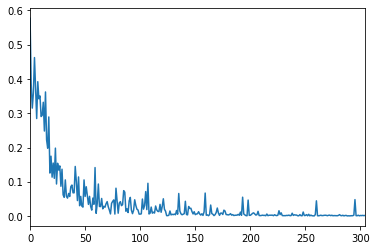

In [17]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

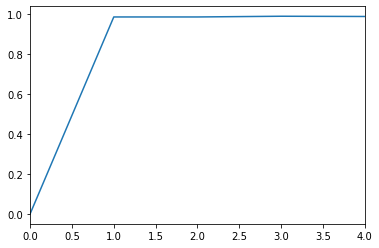

In [18]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy >= 95.

In [19]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
print(test_accuracy)

0.9868263473053892


## Optional Bonus Questions: 
(If you scored full mark (total: 100) in all previous sections, you won't get additional marks so you probably won't need this. But you will get additional bonus marks for answering this if your score is below 100.)

1. What are the problems with recurrent neural networks (RNNs) and how do we overcome them?

2. What is the benefit of using the mean or max pooling of hidden states of LSTM instead of using the last hidden state of LSTM?

## Answers:

1. Instability. Since RNN constantly feed the outputs to the networks as input, the training process of RNN is not esay. The error surface of RNN is either very flat or very steep. So the Loss curve can be very bumpy. It is possible for the updated to the weight to be so large that the weights either overflow or underflow their numerical precision.
To solve the problem, a method called clipping is widely used in RNN. If gradient is larger than the threshold, use the threshold instead of the actual gradient to run the gradient descent process. 
 

2. First, Pooling can help the model to obtain a fixed-length vector in before outputing the vectors to linear classifiers. Secondly, Pooling can picking the maximum values of the feature, which means the most dominant features or averaged all the features. This action integrate the features and reduce the noise.